In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats
from scipy.stats import linregress

from sigmalypse.main import MetricsLab
from sigmalypse.main import MeasureBOda

In [2]:
df_tracker = pd.read_csv('./data/tracker.csv', sep=";")
df_tracker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       965 non-null    float64
 1   mass A  75 non-null     float64
 2   mass B  61 non-null     float64
 3   mass C  60 non-null     float64
 4   mass D  64 non-null     float64
 5   mass E  64 non-null     float64
 6   mass F  52 non-null     float64
 7   mass G  67 non-null     float64
 8   mass H  62 non-null     float64
 9   mass I  66 non-null     float64
 10  mass J  74 non-null     float64
 11  mass K  77 non-null     float64
 12  mass L  55 non-null     float64
 13  mass M  54 non-null     float64
 14  mass N  69 non-null     float64
 15  mass O  65 non-null     float64
dtypes: float64(16)
memory usage: 120.8 KB


In [3]:
mass_columns = [col for col in df_tracker.columns if col.startswith('mass')]
tables = [df_tracker[['t', col]].dropna() for col in mass_columns]

In [4]:
def plot_tables(tables):
    n = len(tables)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=False)

    axes = axes.flatten()

    for i, table in enumerate(tables):
        axes[i].plot(table['t'], table.iloc[:, 1], marker='o')
        axes[i].set_ylabel('Posición')
        axes[i].set_xlabel('Tiempo')
        axes[i].set_title(f'Deslizador lazamiento #{i+1} vs Tiempo')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def remove_flat_start(df, tolerance=0.05, min_points=5):
    pos = df.iloc[:, 1].values

    # Compara cada punto con el primero
    for i in range(1, len(pos) - min_points):
        window = pos[i:i + min_points]
        diffs = abs(window - pos[0])

        # Si al menos un punto en la ventana difiere más que la tolerancia, se corta ahí
        if (diffs > tolerance).any():
            return df.iloc[i:].reset_index(drop=True)

    return df.copy()

def merge_tables_simple(tables):
    merged = []
    for table in tables:
        temp = table.copy()
        temp.columns = ['t', 'posición']
        merged.append(temp)
    return pd.concat(merged, ignore_index=True)

def cut_at_max_position(df):
    max_idx = df.iloc[:, 1].idxmax()
    return df.loc[:max_idx].reset_index(drop=True)

def normalize_time(df):
    df = df.copy()
    df['t'] = df['t'] - df['t'].iloc[0]
    return df

def normalize_origin(df):
    df = df.copy()
    df['t'] = df['t'] - df['t'].min()
    df['posición'] = df['posición'] - df['posición'].min()
    return df

def round_sig(x, n=2):
    if pd.isnull(x) or x == 0:
        return x
    else:
        return float(f"{x:.{n}g}")

def time_to_seconds(value):
    """
    Convierte un string "MM:SS.s" a segundos (float).
    Si recibe un float/int, asume que ya está en segundos.
    """
    if pd.isna(value):
        return np.nan

    # Si ya es numérico, lo dejamos tal cual:
    if isinstance(value, (float, int)):
        return float(value)

    # Si es string:
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        minutes, seconds = value.split(":")
        return int(minutes) * 60 + float(seconds)

    return np.nan

def taylor_mean_and_error(values):
    """
    Recibe una columna/serie de tiempos en segundos (float).
    Devuelve una tupla (mean, error).
    Método basado en John R. Taylor, error tipo A.
    """
    valid = [float(v) for v in values if not pd.isna(v)]
    n = len(valid)
    if n == 0:
        return (np.nan, np.nan)  # sin datos
    mean = np.mean(valid)
    if n == 1:
        # con un solo dato, el error es indeterminado
        error = np.nan
    else:
        error = np.sqrt(np.sum((valid - mean) ** 2) / (n * (n - 1)))
    return (mean, error)


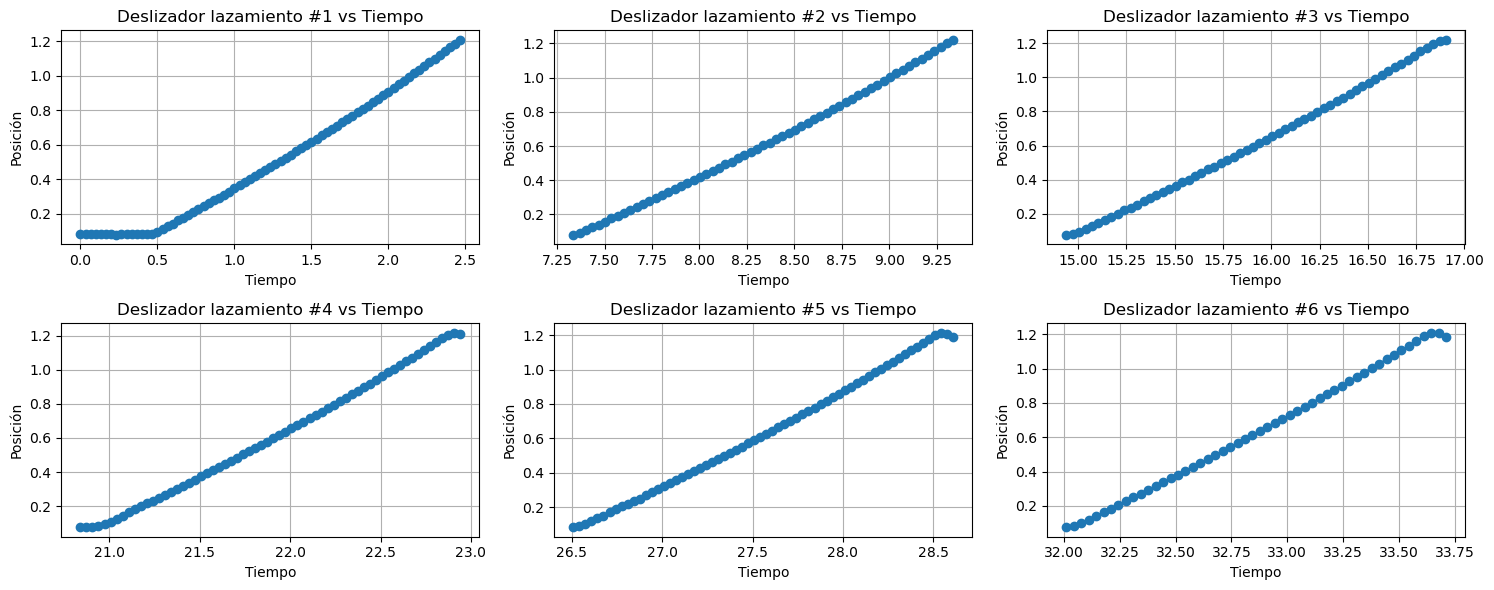

In [5]:
plot_tables(tables[:6])

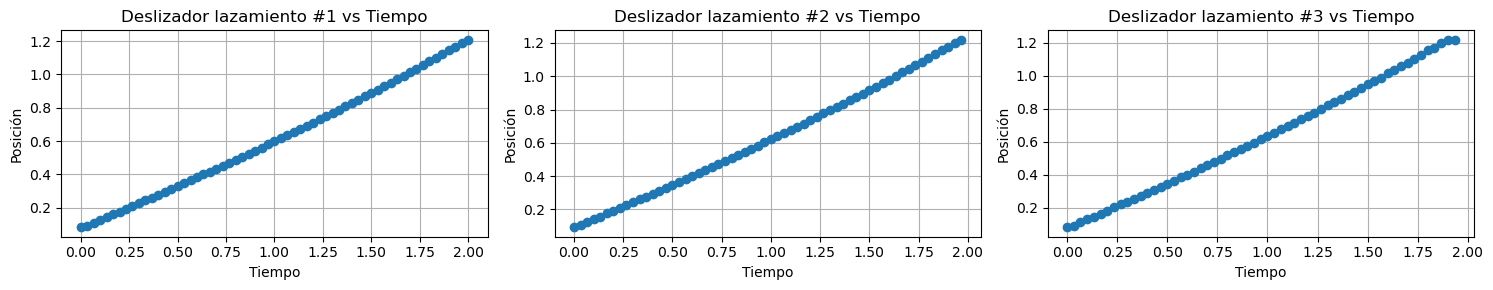

In [6]:
tables = [cut_at_max_position(df) for df in tables]
tables = [remove_flat_start(df) for df in tables]
tables = [normalize_time(df) for df in tables]
plot_tables(tables[:3])

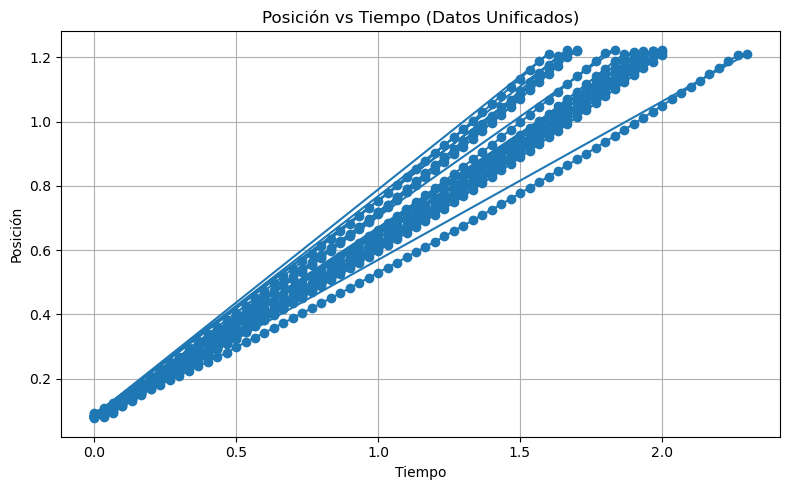

In [7]:
df = merge_tables_simple(tables)

plt.figure(figsize=(8, 5))
plt.plot(df['t'], df['posición'], marker='o')
plt.xlabel('Tiempo')
plt.ylabel('Posición')
plt.title('Posición vs Tiempo (Datos Unificados)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df = normalize_origin(df)

# Agrupa por tiempo y calcula la media
summary_df = df.groupby('t').agg(
    media_posición=('posición', 'mean')
).reset_index()

# Extrae valores
x = summary_df['t'].values
y = summary_df['media_posición'].values

# Mínimos cuadrados
slope = np.sum(x * y) / np.sum(x ** 2)
y_pred = slope * x

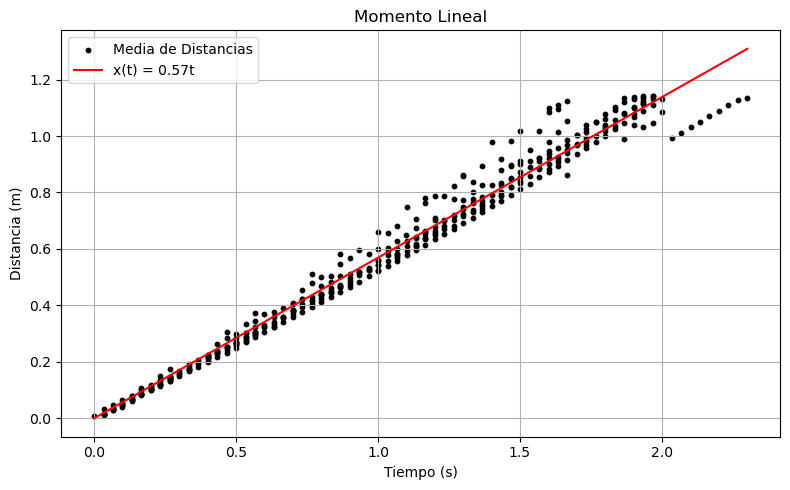

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label='Media de Distancias', color='black', s=10)
plt.plot(x, y_pred, label=f'x(t) = {slope:.2f}t', color='red')

plt.xlabel('Tiempo (s)')
plt.ylabel('Distancia (m)')
plt.title('Momento Lineal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
n = len(x)

# Residuos: diferencia entre valores reales y los predichos por la recta
residuos = y - y_pred

# Cálculo de la desviación estándar de la pendiente (Taylor)
suma_residuos_cuadrado = np.sum(residuos ** 2)
suma_x_cuadrado = np.sum(x ** 2)
std_slope = np.sqrt((1 / (n - 1)) * (suma_residuos_cuadrado / suma_x_cuadrado))

# Imprimir resultados
print(f"Velocidad (pendiente): {slope:.3f} m")
print(f"Desviación estándar de la pendiente (σ_m): {std_slope:.3f} m/s")
print(f"Momento lineal de deslizador: {0.2098 * slope:.3f} kg·m/s")

Velocidad (pendiente): 0.569 m
Desviación estándar de la pendiente (σ_m): 0.002 m/s
Momento lineal de deslizador: 0.119 kg·m/s


In [11]:
df_lineal = pd.read_csv('./data/momento_lineal.csv')

In [12]:
df_team = pd.read_csv('./data/vueltas.csv')

In [13]:
for col in ['O1', 'O2', 'O3']:
    df_team[col] = df_team[col].apply(time_to_seconds)

df_long = df_team.melt(
    id_vars=['integrante', 'vuelta'],
    value_vars=['O1', 'O2', 'O3'],
    var_name='observador',
    value_name='tiempo_segundos'
)

df_stats = (
    df_long
    .groupby(['integrante', 'observador'])['tiempo_segundos']
    .apply(taylor_mean_and_error)
    .reset_index(name='mean_error_tuple')
)

df_stats['mean_time'], df_stats['std_error'] = zip(*df_stats['mean_error_tuple'])
df_stats.drop(columns=['mean_error_tuple'], inplace=True)

mean_table = df_stats.pivot(
    index='integrante',
    columns='observador',
    values='mean_time'
).round(2)

error_table = df_stats.pivot(
    index='integrante',
    columns='observador',
    values='std_error'
).round(2)

print("\nPROMEDIO DE TIEMPOS (segundos):")
print(mean_table)

print("\nERROR ESTÁNDAR (segundos):")
print(error_table)


PROMEDIO DE TIEMPOS (segundos):
observador     O1     O2     O3
integrante                     
Angel       61.77  63.03  61.80
Ricardo     61.40  63.57  62.37
Yam         86.50  88.50  88.87

ERROR ESTÁNDAR (segundos):
observador    O1    O2    O3
integrante                  
Angel       0.99  1.11  0.70
Ricardo     0.60  0.55  0.43
Yam         1.23  1.50  1.13


In [14]:
df_time_mean = mean_table.mean(axis=1)  # Promedio de cada fila

# 2) Definir la distancia recorrida
distance = 90.0  # metros

# 3) Calcular la velocidad en m/s
df_speed = distance / df_time_mean

# 4) Opcional: redondear a 2 decimales
df_speed = df_speed.round(2)

# 5) Mostrar resultados
print("Tiempo promedio único por integrante (s):")
print(df_time_mean)

print("\nVelocidad promedio por integrante (m/s):")
print(df_speed)


Tiempo promedio único por integrante (s):
integrante
Angel      62.200000
Ricardo    62.446667
Yam        87.956667
dtype: float64

Velocidad promedio por integrante (m/s):
integrante
Angel      1.45
Ricardo    1.44
Yam        1.02
dtype: float64


In [15]:
overall_time = mean_table.mean(axis=1)

# 2) Define the distance (meters) and compute the overall velocity (m/s)
distance = 90.0  # meters
velocity = distance / overall_time  # velocity in m/s

# 3) Mass dictionary (in kilograms)
masses = {
    'angel': 80,
    'ricardo': 80,
    'yam': 60
}

print("Overall velocity, momentum, and kinetic energy per person:\n")
for person in overall_time.index:
    mass = masses.get(person.lower(), None)
    if mass is not None:
        v = velocity.loc[person]
        momentum = mass * v
        kinetic_energy = 0.5 * mass * (v ** 2)
        print(f"{person.capitalize()}:")
        print(f"  Volocidad: {v:.2f} m/s")
        print(f"  Momento: {momentum:.2f} kg·m/s")
        print(f"  Energía cinética: {kinetic_energy:.2f} J\n")
    else:
        print(f"{person.capitalize()}: unknown mass.\n")

Overall velocity, momentum, and kinetic energy per person:

Angel:
  Volocidad: 1.45 m/s
  Momento: 115.76 kg·m/s
  Energía cinética: 83.75 J

Ricardo:
  Volocidad: 1.44 m/s
  Momento: 115.30 kg·m/s
  Energía cinética: 83.09 J

Yam:
  Volocidad: 1.02 m/s
  Momento: 61.39 kg·m/s
  Energía cinética: 31.41 J



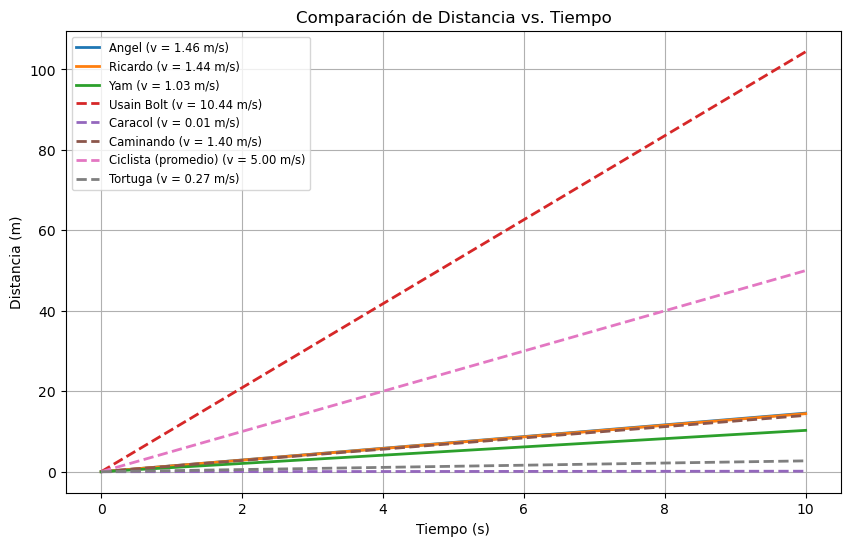

In [16]:
velocity = pd.Series({
    'Angel': 90.0/61.8,
    'Ricardo': 90.0/62.37,
    'Yam': 90.0/87.53
})

referencias = {
    "Usain Bolt": 10.44,
    "Caracol": 0.013,
    "Caminando": 1.4,
    "Ciclista (promedio)": 5.0,
    "Tortuga": 0.27
}

rango_tiempo = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 6))

for persona in velocity.index:
    v = velocity.loc[persona]
    distancia = v * rango_tiempo
    plt.plot(rango_tiempo, distancia, linewidth=2,
             label=f'{persona.capitalize()} (v = {v:.2f} m/s)')

for etiqueta, v_ref in referencias.items():
    distancia_ref = v_ref * rango_tiempo
    plt.plot(rango_tiempo, distancia_ref, linestyle='--', linewidth=2,
             label=f'{etiqueta} (v = {v_ref:.2f} m/s)')

plt.xlabel("Tiempo (s)")
plt.ylabel("Distancia (m)")
plt.title("Comparación de Distancia vs. Tiempo")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()